In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import cycle, islice

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


sns.set(style="darkgrid", font_scale=1.4)
%config InlineBackend.figure_format = 'retina'

In [2]:
n_samples = [20, 50, 100, 250, 500, 1000, 5000, 10000]  # list of sample points for which to genereate data

print(f"Number of Samples: {len(n_samples)}")
print(n_samples)

Number of Samples: 8
[20, 50, 100, 250, 500, 1000, 5000, 10000]


In [3]:
np.random.seed(0)
# base dataset config params
noise=None
shuffle=True
# Create dataset of noisy moons with varying sample sizes 
moons_datasets = [datasets.make_moons(n_samples=sample, noise=noise, shuffle=shuffle) for sample in n_samples] 

### Create neural Network

Simple NN 
```
2 (input) -> 30 (hiden)-> 20 -> 1 (output)
```

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def create_model():
    return nn.Sequential(
        nn.Linear(2, 30),
        nn.ReLU(),
        nn.Linear(30, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    )



model = create_model()
model.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
print(model)

Using cuda device
Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=1, bias=True)
)


In [5]:

def train(dataloader, model, epochs, loss_fn, optimizer, device):
    losses = []
    size = len(dataloader.dataset)
    model.train()
    for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # append loss 
            losses.append(loss.item())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#     print("Done")
    return model, losses

In [6]:
def show_loss(losses):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    
    
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [7]:
def show_separation(model, X, y, canvas=None, title=None, save=False, name_to_save=""):
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = torch.sigmoid(model(batch).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

    if canvas is None:
        f, ax = plt.subplots(figsize=(16, 10))
    else:
        f, ax = canvas
    ax.set_title(title if title else "Decision boundary" , fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
#     ax_c = f.colorbar(contour)
#     ax_c.set_label("$P(y = 1)$")
#     ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    if save:
        plt.savefig(name_to_save)
#     else:
#         plt.show()

#### run classification on single 50 sample dataset first

In [ ]:
X, y = moons_datasets[0]
y = np.reshape(y, (len(y),1))

In [ ]:
len(y)

In [ ]:
# plt.figure(figsize=(16, 10))

plt.title("Dataset")
colors = np.array(['red', 'green'])
plt.scatter(X[:, 0], X[:, 1], color=list(colors[y.flatten()]))
plt.show()

In [ ]:
# split the dataset into tain/validation:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)  # 75/25 train/test split


plt.figure(figsize=(14, 5))
plt.subplot(1,2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], color=list(colors[y_train.flatten()]))

# get x and y ranges for the plots so that all plot ranges are the same.
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()
print(y_min, y_max)

plt.subplot(1,2, 2)
plt.scatter(X_val[:, 0], X_val[:, 1], color=list(colors[y_val.flatten()]))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [ ]:
y.shape

In [ ]:
# Convert to torch.tensor:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

In [ ]:
# And make TensorDataset's from them:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset,batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [ ]:
model, losses = train(train_dataloader, model, 3000, loss_function, optimizer, device)
show_loss(losses)

In [ ]:
model = model.to("cpu")
show_separation(model, X_train, y_train.flatten())

### Run classification on all

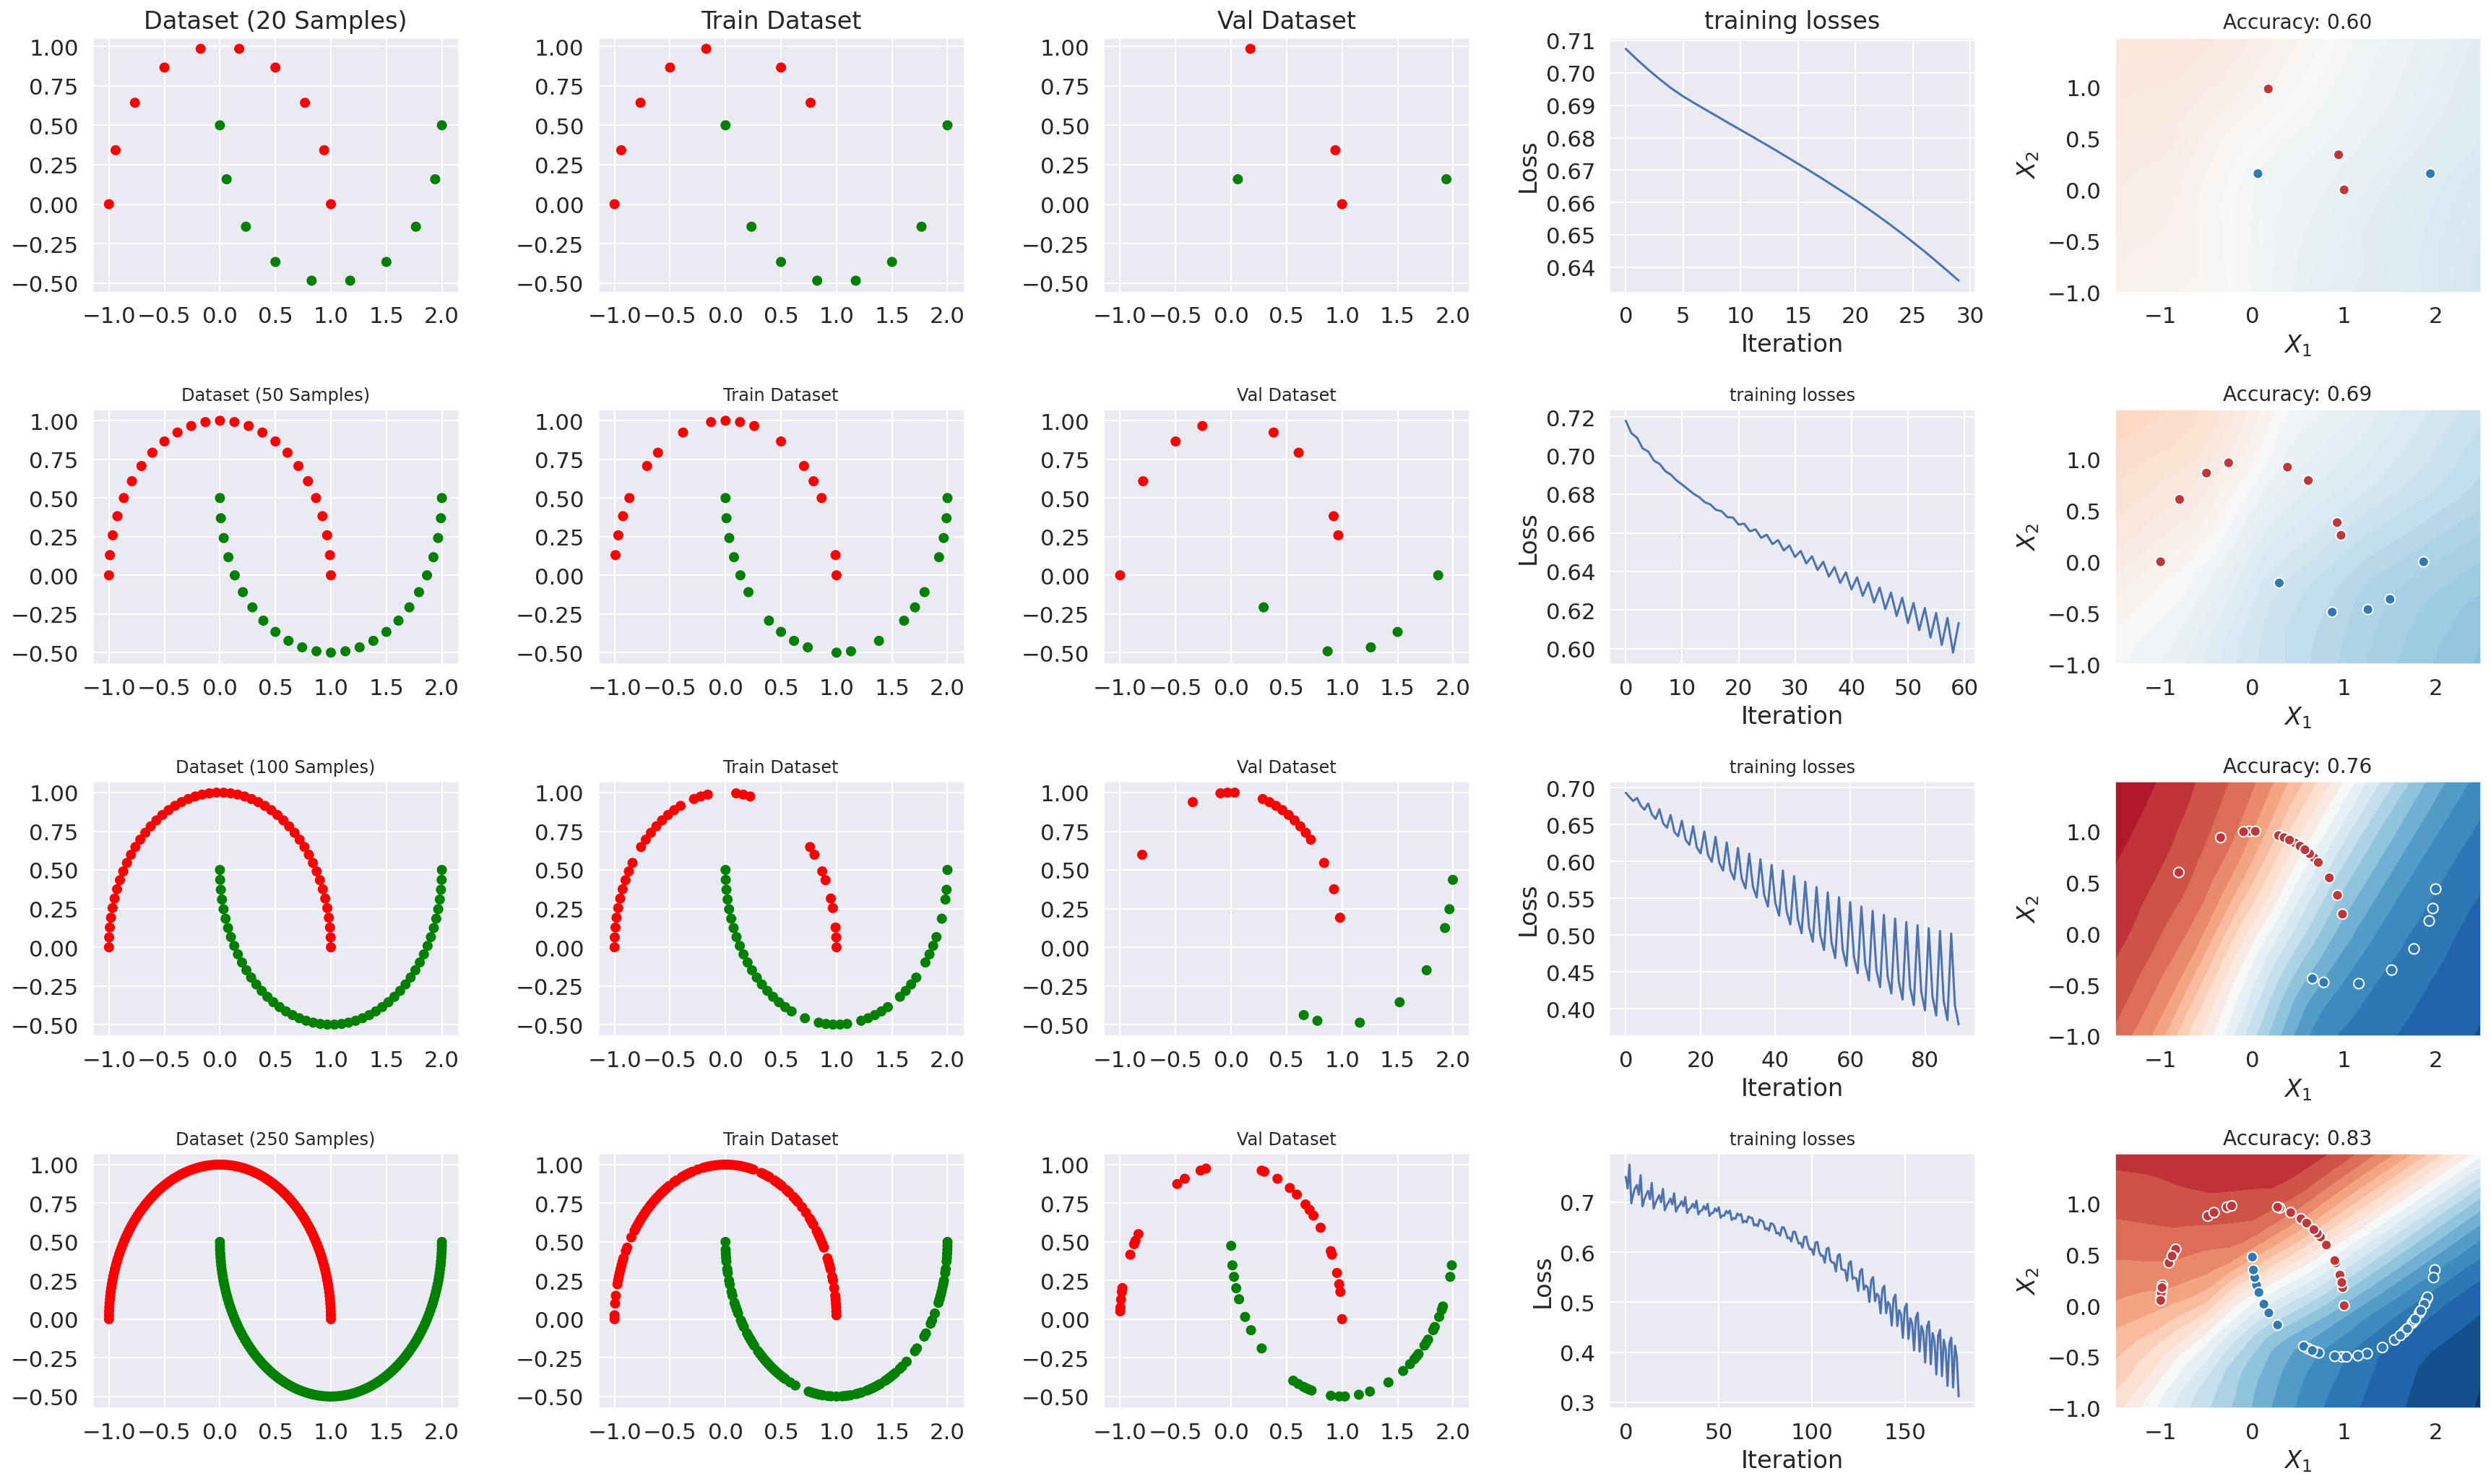

In [8]:
# configs
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
fig.tight_layout(pad=3)
number_of_epochs = 30
batch_size = 32

accuracy_per_num_of_samples_base = []

for i, dataset in enumerate(moons_datasets[:4]):
    X, y = dataset
    y = np.reshape(y, (len(y),1))  # reshape to be (len(y), 1) vector instead of a flat array
    
    # split the dataset into tain/validation:
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)  # 75/25 train/test split
    
    # Convert to torch.tensor:
    X_train_t = torch.from_numpy(X_train).to(torch.float32)
    y_train_t = torch.from_numpy(y_train).to(torch.float32)
    X_val_t = torch.from_numpy(X_val).to(torch.float32)
    y_val_t = torch.from_numpy(y_val).to(torch.float32)

    # And make TensorDataset's from them:
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    
    #define model, loss, and optimizer
    model = create_model()
    model.to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    
    model, losses = train(train_dataloader, model, number_of_epochs, loss_function, optimizer, device)
    
    # plot the data it self
    ax[i, 0].set_title(f"Dataset ({len(y)} Samples)")
    colors = np.array(['red', 'green'])
    ax[i ,0].scatter(X[:, 0], X[:, 1], color=list(colors[y.flatten()]))
    # get x and y range from the plotted dataset 
    x_min, x_max = ax[i, 0].get_xlim()
    y_min, y_max = ax[i, 0].get_ylim()
#     print(x_min, x_max, y_min, y_max)
    
    
    # plot train
    ax[i, 1].set_title("Train Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 1].scatter(X_train[:, 0], X_train[:, 1], color=list(colors[y_train.flatten()]))
    # set x and y ranges
    ax[i, 1].set_xlim(x_min, x_max)
    ax[i, 1].set_ylim(y_min, y_max)
    
    
    # plot val
    ax[i, 2].set_title("Val Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 2].scatter(X_val[:, 0], X_val[:, 1], color=list(colors[y_val.flatten()]))
    # set x and y ranges
    ax[i, 2].set_xlim(x_min, x_max)
    ax[i, 2].set_ylim(y_min, y_max)
        
    
    # plot losses
    ax[i, 3].set_title("training losses")
    ax[i, 3].plot(range(len(losses)), losses)
    ax[i, 3].set_xlabel("Iteration")
    ax[i, 3].set_ylabel("Loss")
    
    
    # plot decision boundry
    model.to("cpu")
    accuracy= accuracy_score(y_val, predict(val_dataloader, model))
    accuracy_per_num_of_samples_base.append(accuracy)
    show_separation(model, X_val, y_val.flatten(), (fig,ax[i, 4]), title=f"Accuracy: {accuracy:.2f}")
    
    
    
    

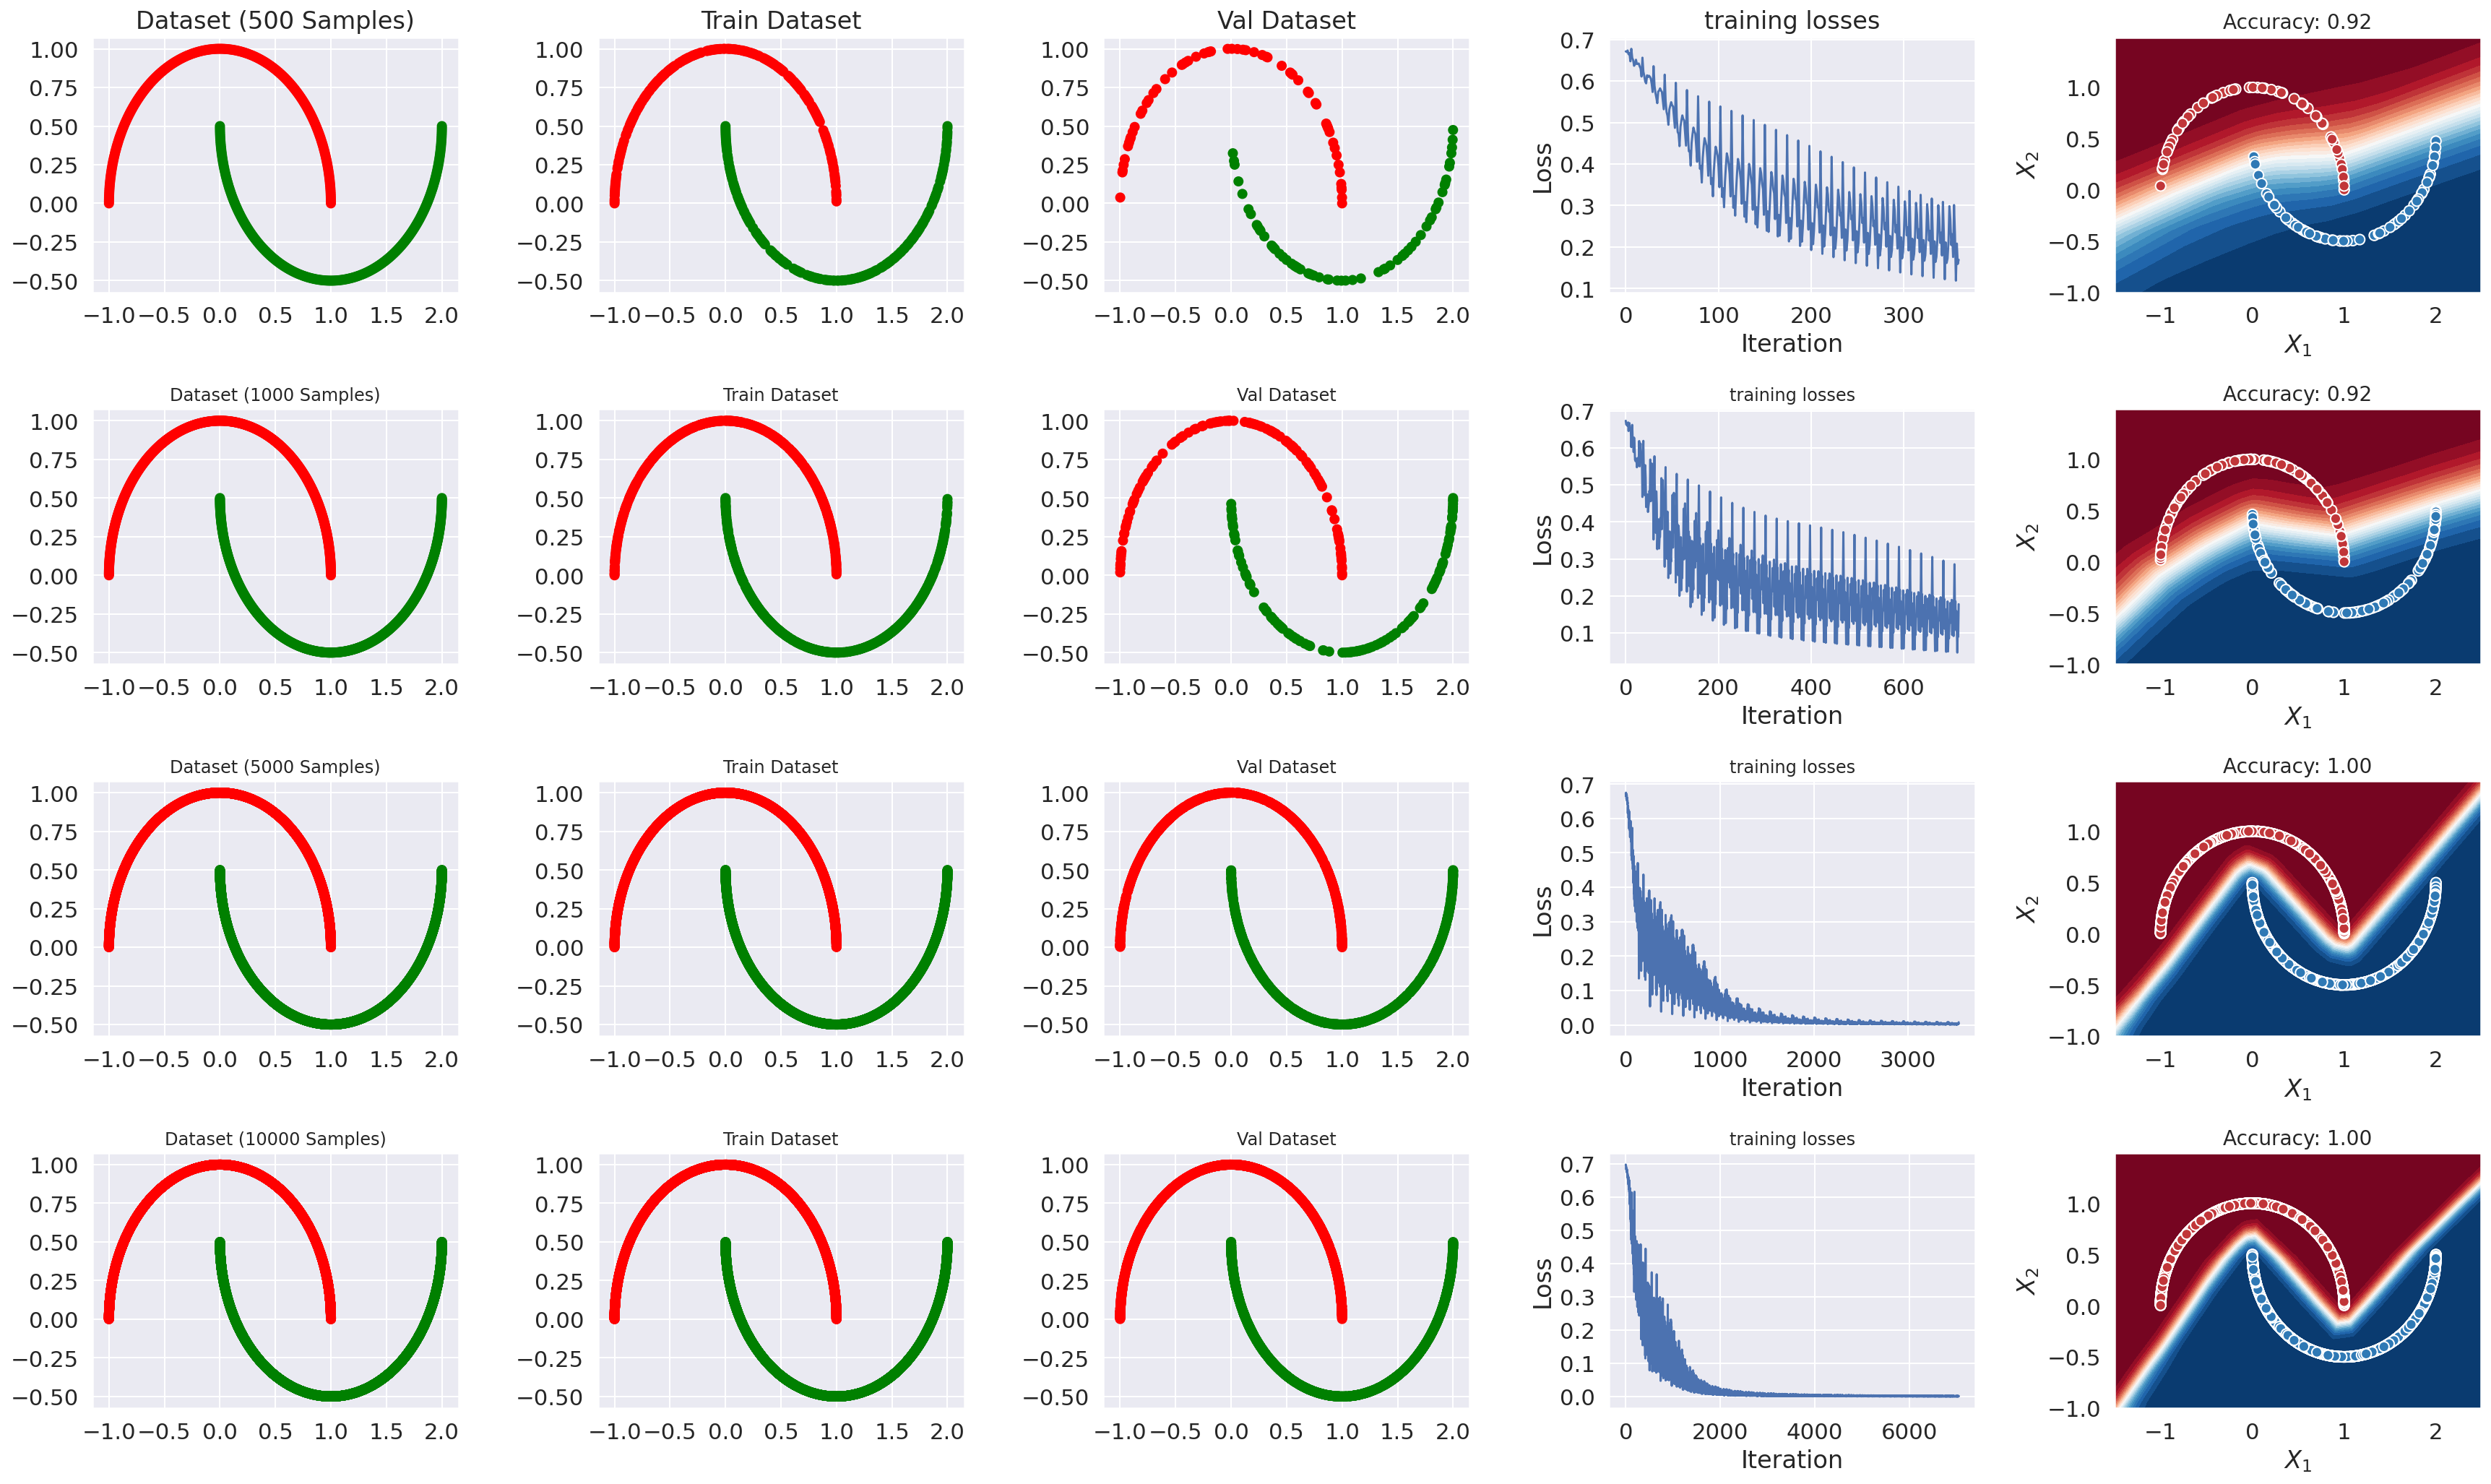

In [9]:
sns.set(style="darkgrid", font_scale=1.4)
# configs
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
fig.tight_layout(pad=3)


for i, dataset in enumerate(moons_datasets[4:]):
    X, y = dataset
    y = np.reshape(y, (len(y),1))  # reshape to be (len(y), 1) vector instead of a flat array
    
    # split the dataset into tain/validation:
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)  # 75/25 train/test split
    
    # Convert to torch.tensor:
    X_train_t = torch.from_numpy(X_train).to(torch.float32)
    y_train_t = torch.from_numpy(y_train).to(torch.float32)
    X_val_t = torch.from_numpy(X_val).to(torch.float32)
    y_val_t = torch.from_numpy(y_val).to(torch.float32)

    # And make TensorDataset's from them:
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    
    #define model, loss, and optimizer
    model = create_model()
    model.to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    
    model, losses = train(train_dataloader, model, number_of_epochs, loss_function, optimizer, device)
    
    # plot the data it self
    ax[i, 0].set_title(f"Dataset ({len(y)} Samples)")
    colors = np.array(['red', 'green'])
    ax[i ,0].scatter(X[:, 0], X[:, 1], color=list(colors[y.flatten()]))
    # get x and y range from the plotted dataset 
    x_min, x_max = ax[i, 0].get_xlim()
    y_min, y_max = ax[i, 0].get_ylim()
#     print(x_min, x_max, y_min, y_max)
    
    
    # plot train
    ax[i, 1].set_title("Train Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 1].scatter(X_train[:, 0], X_train[:, 1], color=list(colors[y_train.flatten()]))
    # set x and y ranges
    ax[i, 1].set_xlim(x_min, x_max)
    ax[i, 1].set_ylim(y_min, y_max)
    
    
    # plot val
    ax[i, 2].set_title("Val Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 2].scatter(X_val[:, 0], X_val[:, 1], color=list(colors[y_val.flatten()]))
    # set x and y ranges
    ax[i, 2].set_xlim(x_min, x_max)
    ax[i, 2].set_ylim(y_min, y_max)
        
    
    # plot losses
    ax[i, 3].set_title("training losses")
    ax[i, 3].plot(range(len(losses)), losses)
    ax[i, 3].set_xlabel("Iteration")
    ax[i, 3].set_ylabel("Loss")
    
    
    # plot decision boundry
    model.to("cpu")
    accuracy= accuracy_score(y_val, predict(val_dataloader, model))
    accuracy_per_num_of_samples_base.append(accuracy)
    show_separation(model, X_val, y_val.flatten(), (fig,ax[i, 4]), title=f"Accuracy: {accuracy:.2f}")
    
    

### plot accuracy metrics 

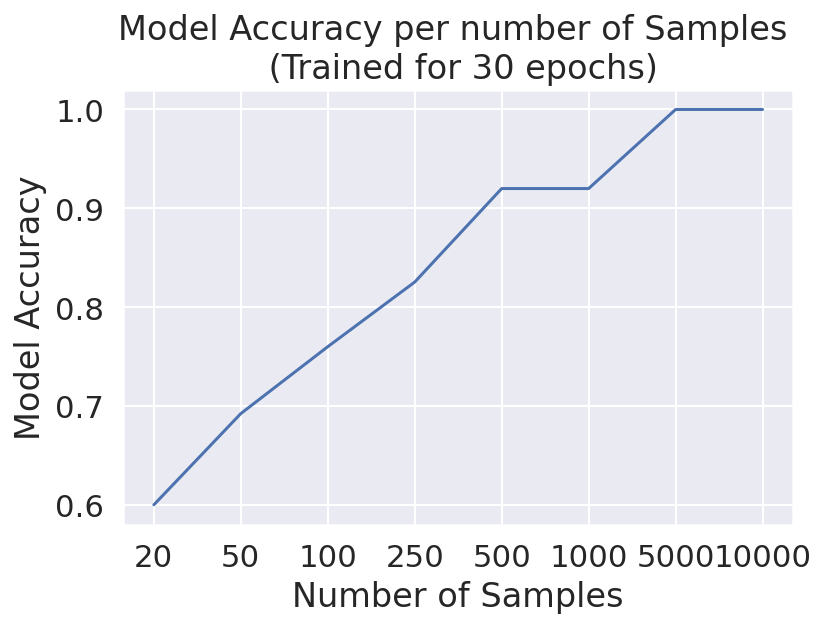

In [10]:
sns.set(style="darkgrid", font_scale=1.4)
plt.xticks(range(len(n_samples)), n_samples)
plt.plot(range(len(n_samples)), accuracy_per_num_of_samples_base)
plt.xlabel("Number of Samples")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy per number of Samples \n (Trained for {number_of_epochs} epochs)")
plt.show()

### add new data points to existing datasets and add gaussian noise to them

In [11]:
rng = np.random.default_rng(seed=0)

def augment_data(X, y, noise=0.05, iterations=1):
    original_X, original_y = X.copy(), y.copy()
    
    new_X, new_y = X.copy(), y.copy()
    for _ in range(iterations):
        augmented_X, augmented_y = original_X.copy(), original_y.copy()
        augmented_X += rng.normal(scale=noise, size=augmented_X.shape)
        new_X, new_y = np.vstack((new_X, augmented_X)), np.vstack((new_y, augmented_y))
        
    return new_X, new_y

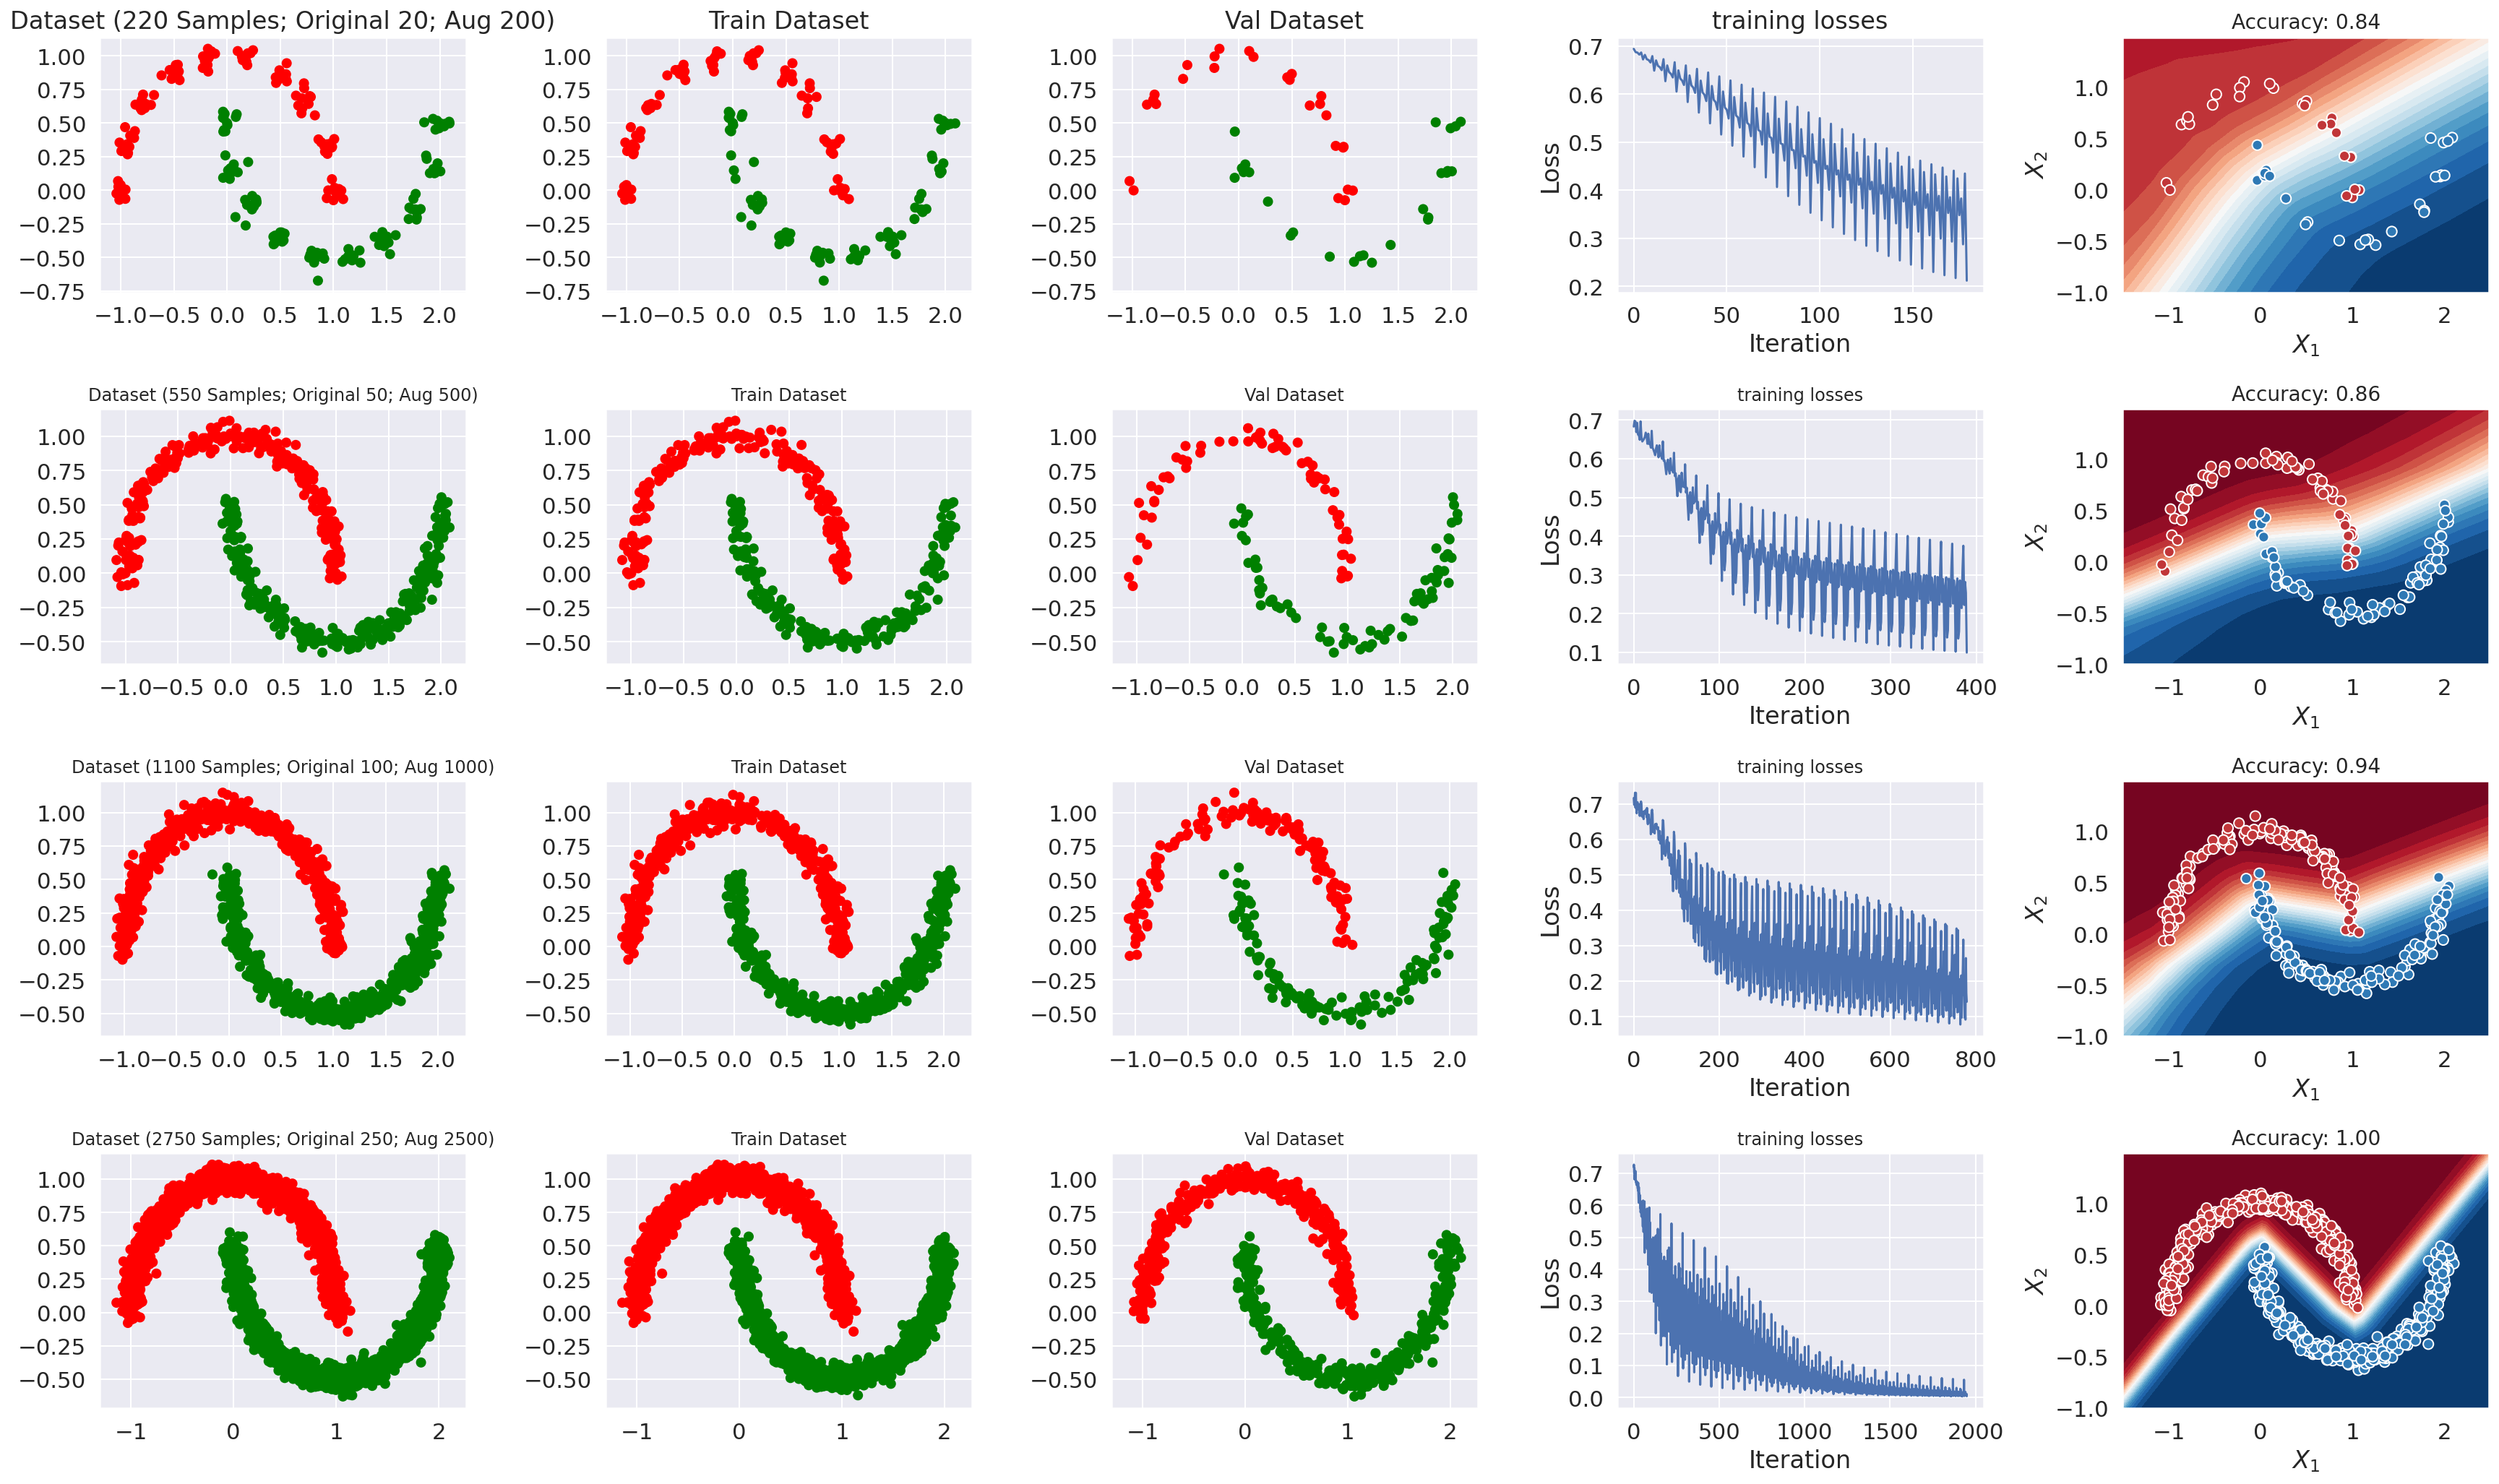

In [12]:
sns.set(style="darkgrid", font_scale=1.4)
# configs
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
fig.tight_layout(pad=3)
number_of_epochs = 30
batch_size = 32
augmentation_iters = 10

accuracy_per_num_of_samples_aug = []

for i, dataset in enumerate(moons_datasets[:4]):
    X, y = dataset
    y = np.reshape(y, (len(y),1))  # reshape to be (len(y), 1) vector instead of a flat array
    original_size = len(y)
    # augment dataset
    X, y = augment_data(X, y, iterations=augmentation_iters)
    
    
    # split the dataset into tain/validation:
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)  # 75/25 train/test split
    
    # Convert to torch.tensor:
    X_train_t = torch.from_numpy(X_train).to(torch.float32)
    y_train_t = torch.from_numpy(y_train).to(torch.float32)
    X_val_t = torch.from_numpy(X_val).to(torch.float32)
    y_val_t = torch.from_numpy(y_val).to(torch.float32)

    # And make TensorDataset's from them:
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    
    #define model, loss, and optimizer
    model = create_model()
    model.to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    
    model, losses = train(train_dataloader, model, number_of_epochs, loss_function, optimizer, device)
    
    # plot the data it self
    ax[i, 0].set_title(f"Dataset ({len(y)} Samples; Original {original_size}; Aug {len(y)-original_size})")
    colors = np.array(['red', 'green'])
    ax[i ,0].scatter(X[:, 0], X[:, 1], color=list(colors[y.flatten()]))
    # get x and y range from the plotted dataset 
    x_min, x_max = ax[i, 0].get_xlim()
    y_min, y_max = ax[i, 0].get_ylim()
#     print(x_min, x_max, y_min, y_max)
    
    
    # plot train
    ax[i, 1].set_title("Train Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 1].scatter(X_train[:, 0], X_train[:, 1], color=list(colors[y_train.flatten()]))
    # set x and y ranges
    ax[i, 1].set_xlim(x_min, x_max)
    ax[i, 1].set_ylim(y_min, y_max)
    
    
    # plot val
    ax[i, 2].set_title("Val Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 2].scatter(X_val[:, 0], X_val[:, 1], color=list(colors[y_val.flatten()]))
    # set x and y ranges
    ax[i, 2].set_xlim(x_min, x_max)
    ax[i, 2].set_ylim(y_min, y_max)
        
    
    # plot losses
    ax[i, 3].set_title("training losses")
    ax[i, 3].plot(range(len(losses)), losses)
    ax[i, 3].set_xlabel("Iteration")
    ax[i, 3].set_ylabel("Loss")
    
    
    # plot decision boundry
    model.to("cpu")
    accuracy= accuracy_score(y_val, predict(val_dataloader, model))
    accuracy_per_num_of_samples_aug.append(accuracy)
    show_separation(model, X_val, y_val.flatten(), (fig,ax[i, 4]), title=f"Accuracy: {accuracy:.2f}")
    
    
    
    

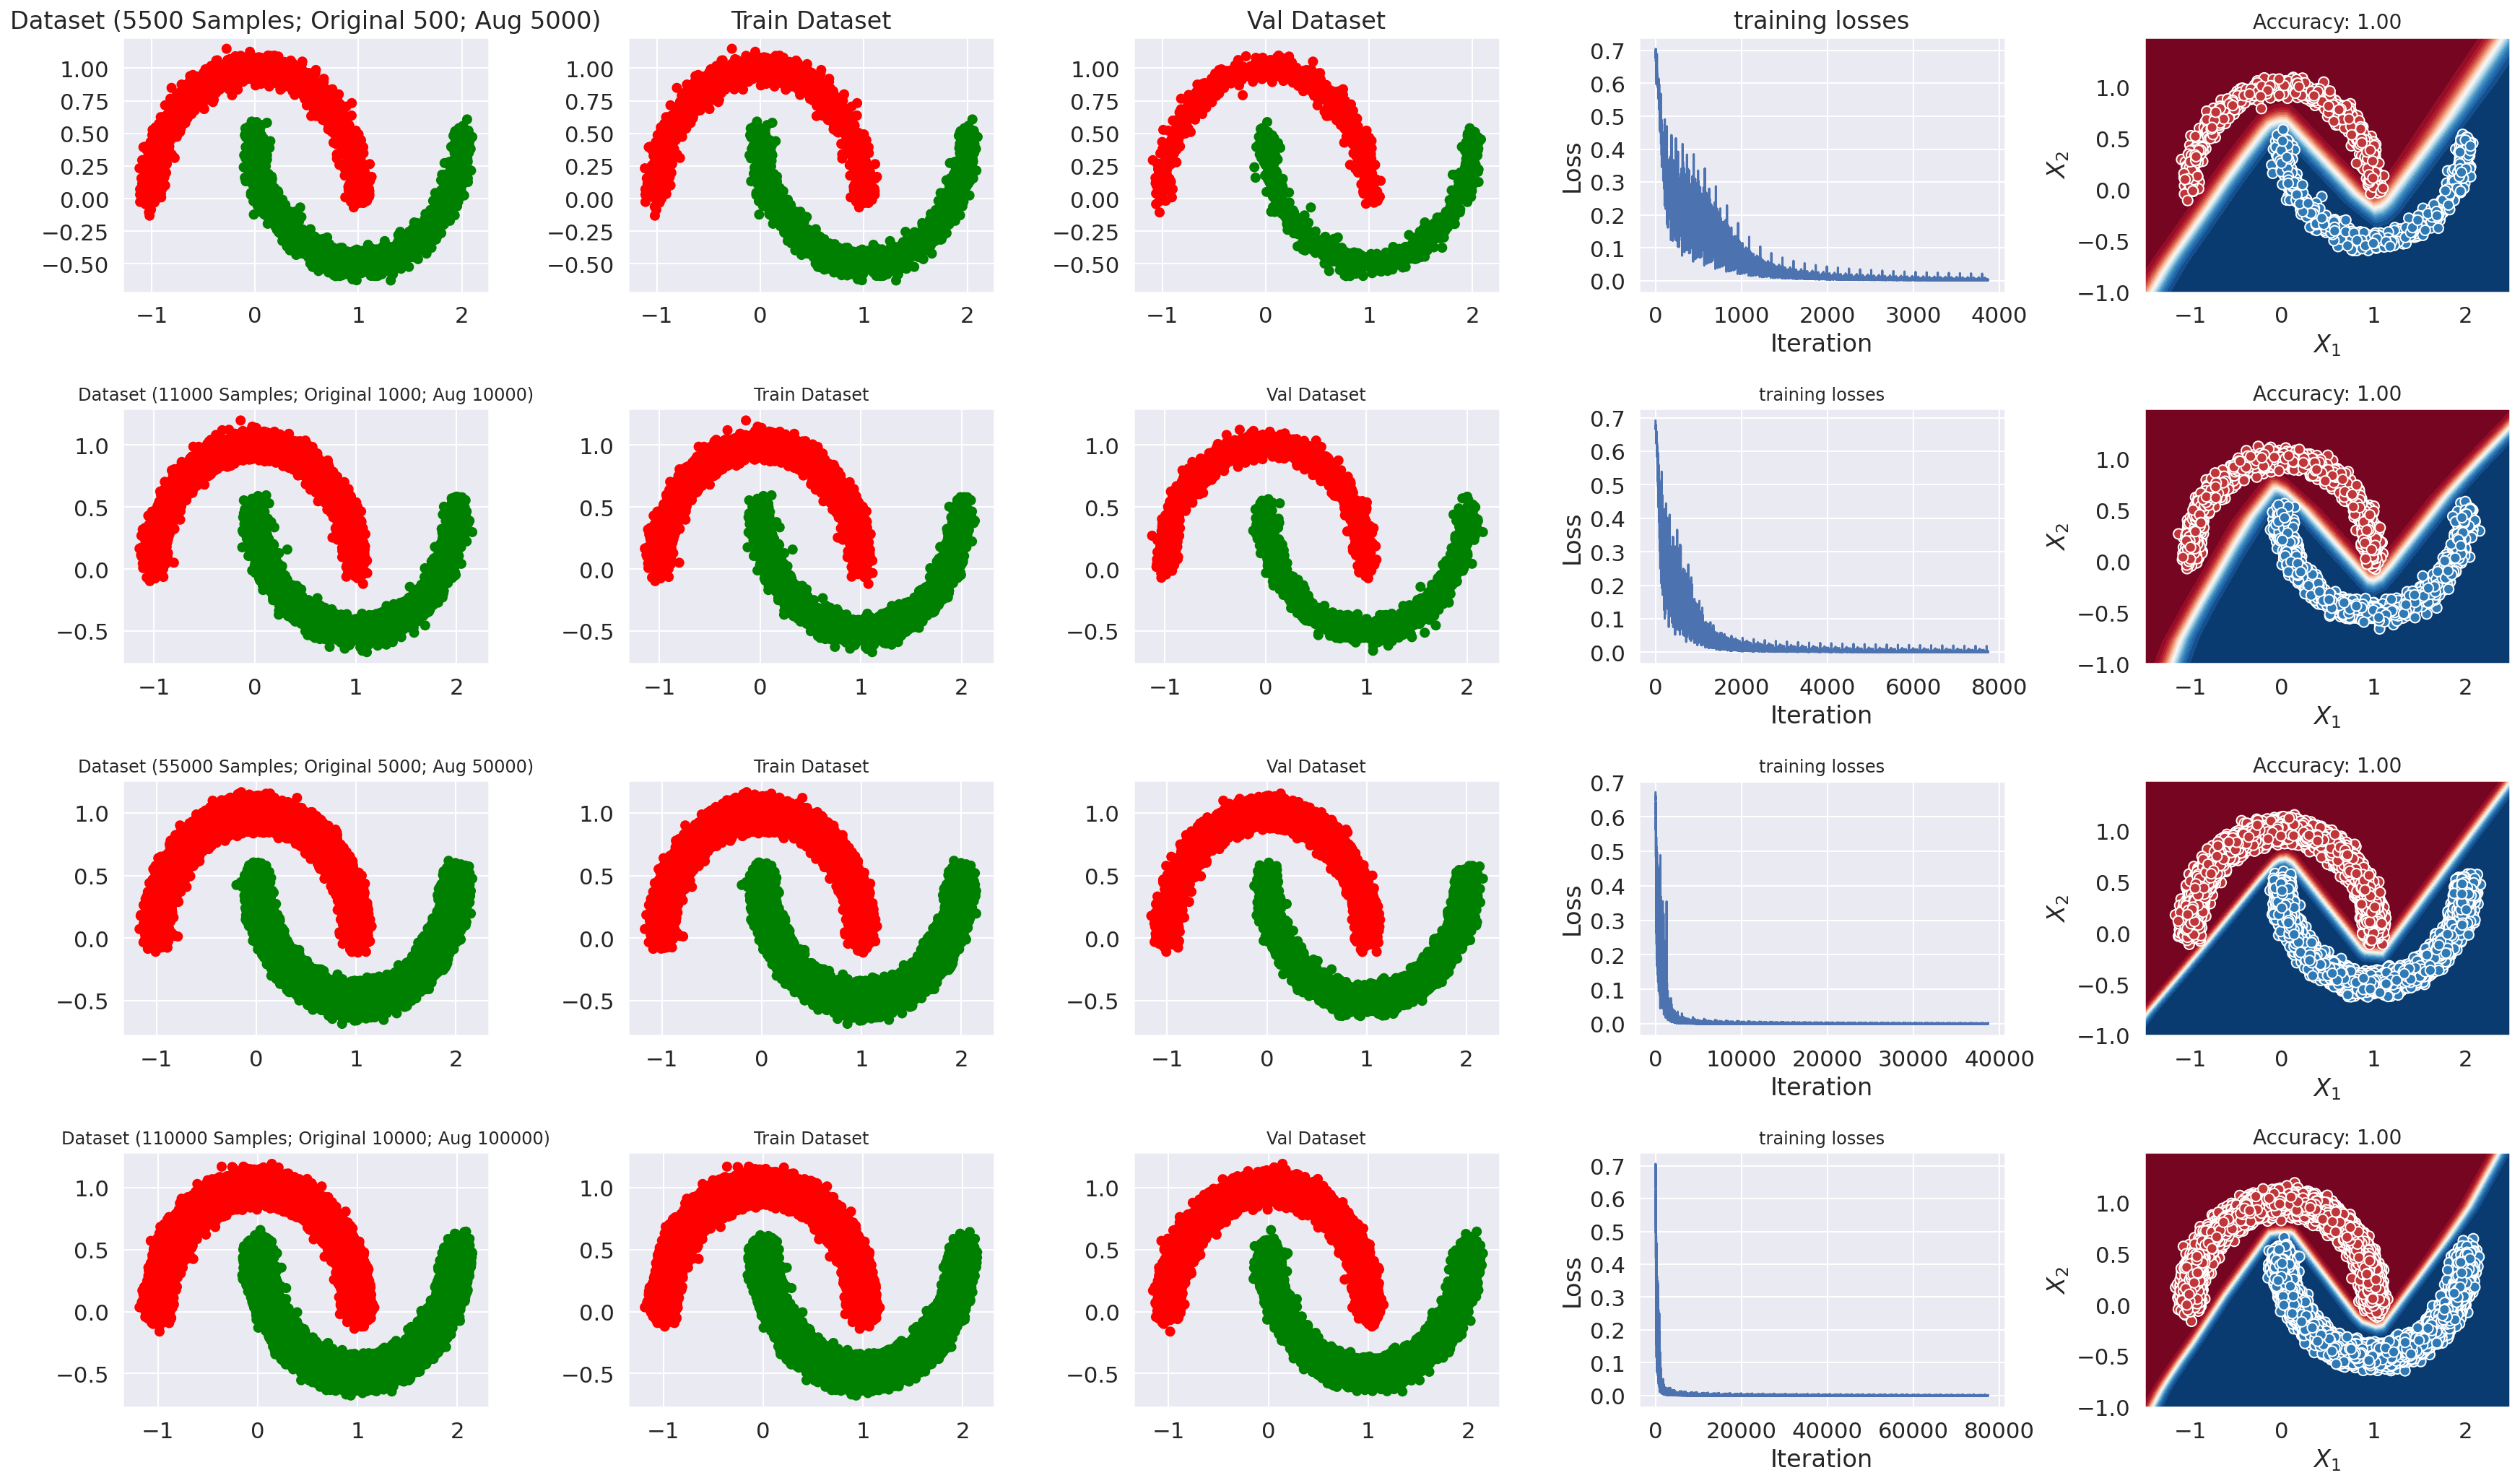

In [13]:
sns.set(style="darkgrid", font_scale=1.4)
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
fig.tight_layout(pad=3)

for i, dataset in enumerate(moons_datasets[4:]):
    X, y = dataset
    y = np.reshape(y, (len(y),1))  # reshape to be (len(y), 1) vector instead of a flat array
    original_size = len(y)
    # augment dataset
    X, y = augment_data(X, y, iterations=augmentation_iters)
    
    
    # split the dataset into tain/validation:
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)  # 75/25 train/test split
    
    # Convert to torch.tensor:
    X_train_t = torch.from_numpy(X_train).to(torch.float32)
    y_train_t = torch.from_numpy(y_train).to(torch.float32)
    X_val_t = torch.from_numpy(X_val).to(torch.float32)
    y_val_t = torch.from_numpy(y_val).to(torch.float32)

    # And make TensorDataset's from them:
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    
    #define model, loss, and optimizer
    model = create_model()
    model.to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    
    model, losses = train(train_dataloader, model, number_of_epochs, loss_function, optimizer, device)
    
    # plot the data it self
    ax[i, 0].set_title(f"Dataset ({len(y)} Samples; Original {original_size}; Aug {len(y)-original_size})")
    colors = np.array(['red', 'green'])
    ax[i ,0].scatter(X[:, 0], X[:, 1], color=list(colors[y.flatten()]))
    # get x and y range from the plotted dataset 
    x_min, x_max = ax[i, 0].get_xlim()
    y_min, y_max = ax[i, 0].get_ylim()
#     print(x_min, x_max, y_min, y_max)
    
    
    # plot train
    ax[i, 1].set_title("Train Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 1].scatter(X_train[:, 0], X_train[:, 1], color=list(colors[y_train.flatten()]))
    # set x and y ranges
    ax[i, 1].set_xlim(x_min, x_max)
    ax[i, 1].set_ylim(y_min, y_max)
    
    
    # plot val
    ax[i, 2].set_title("Val Dataset")
    colors = np.array(['red', 'green'])
    ax[i, 2].scatter(X_val[:, 0], X_val[:, 1], color=list(colors[y_val.flatten()]))
    # set x and y ranges
    ax[i, 2].set_xlim(x_min, x_max)
    ax[i, 2].set_ylim(y_min, y_max)
        
    
    # plot losses
    ax[i, 3].set_title("training losses")
    ax[i, 3].plot(range(len(losses)), losses)
    ax[i, 3].set_xlabel("Iteration")
    ax[i, 3].set_ylabel("Loss")
    
    
    # plot decision boundry
    model.to("cpu")
    accuracy= accuracy_score(y_val, predict(val_dataloader, model))
    accuracy_per_num_of_samples_aug.append(accuracy)
    show_separation(model, X_val, y_val.flatten(), (fig,ax[i, 4]), title=f"Accuracy: {accuracy:.2f}")
    
    
    
    

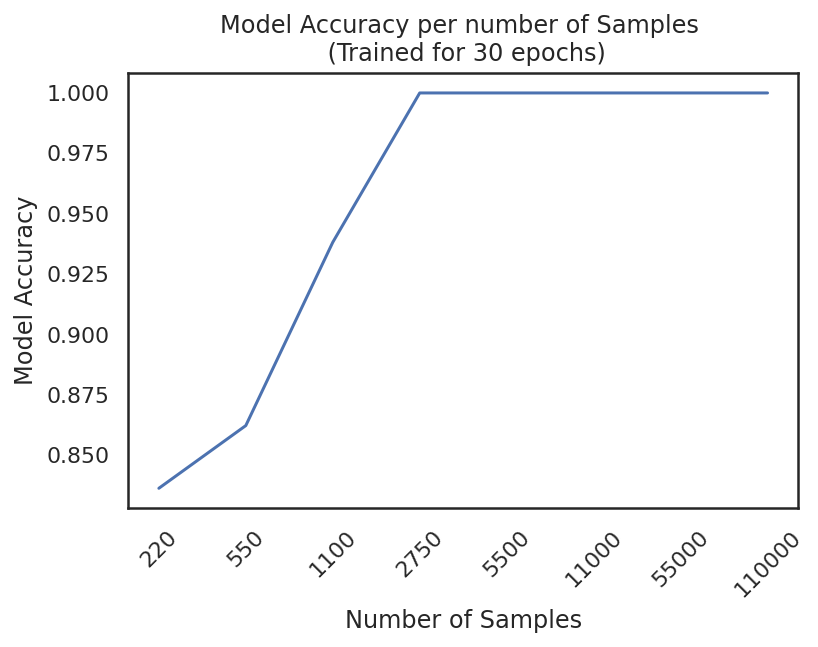

In [14]:
plt.xticks(range(len(n_samples)), np.array(n_samples) + np.array(n_samples)*10, rotation = 45)
plt.plot(range(len(n_samples)), accuracy_per_num_of_samples_aug)
plt.xlabel("Number of Samples")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy per number of Samples \n (Trained for {number_of_epochs} epochs)")
plt.show()

In [ ]:
plt.xticks(range(len(n_samples)), np.array(n_samples) + np.array(n_samples)*10, rotation = 45)
plt.plot(range(len(n_samples)), accuracy_per_num_of_samples_aug)
plt.plot(range(len(n_samples)), accuracy_per_num_of_samples_base)
plt.xlabel("Number of Samples")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy per number of Samples \n (Trained for {number_of_epochs} epochs)")
plt.show()